# Multiplicative Weights and Ensemble Methods - Boosting




The idea of aggregating information from many sources has great utility in machine learning and is the basis behind ensemble methods.

This notebook is going to take a relatively different approach to introducing ensemble methods and boosting. Instead of introducing boosting within the scope of some machine learning application such as decision trees (which was assumedly covered earlier this week or in a previous week), we will first look more broadly at the general algorithmic framework of multiplicative weights, which has wide applications in fields as diverse as game theory and finance. 

Then, we will introduce ensemble methods. First we will look at bagging, and then we will examine boosting in detail. We will walk through an implementation of Adaboost and explore its performance compared to other ensemble method performance on a real life dataset.

Boosting is one example of an ensemble method which has had great success in real-life applications. Indeed, the fundamental ideas behind these concepts are universal, and you have seen them in previous classes such as EECS16B through Orthogonal Matching Pursuit (OMP). For a more conceptual understanding, it is strongly encouraged to read the note in depth. 

To gain intuition of the methods, first, let's explore the general experts framework and introduce the multiplicative weights algorithm.


In [ ]:
# Imports here 
from decimal import *
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, HistGradientBoostingClassifier

#Experts and Multiplicative Weights

## An Experts Framework
In many scenarios, we may have different models or "experts" that are telling us how to go about performing some task. The experts may give conflicting pieces of advice. How should we go about using their advice?

In the simplest, one-day scenario, without any prior on the experts, we would equally consider the advice from each of the experts... In other words, for a discrete classification problem we simply choose the majority rule.

###Task 1: Experts Warmup

As a warmup, let's consider a classic scenario where we are trying to classify a handwritten digit, 0 through 9. Suppose we have  n  experts who give us their response on a single data point. Write a function that will take the majority vote for this case.

For the continuous regression case, we simply take the average. Write a quick function doing that takes the unweighted average of the experts response (the data points).

In [ ]:
# Function that returns the majority rule based off the 
# experts advice. Takes in a list containing each 
# expert's decision and an int representing the number of experts n,
# and returns the digit corresponding to the majority.
def discrete_classification_majority(experts, n):
  
  #YOUR CODE HERE
  return max(set(experts), key = experts.count)

n = 5
experts1 = [0, 2, 2, 5, 2]
experts2 = [0, 0, 2, 5, 7]
print(discrete_classification_majority(experts1, n)) # should return 2.
print(discrete_classification_majority(experts2, n)) # should return 0.


#continuous version. Return the average of the experts' responses
def continuous_classification_average(experts, n):
  
  #YOUR CODE HERE
  return sum(experts) / len(experts)

experts3 = [-1,0,1]
print(continuous_classification_average(experts3, 3)) #should return 0.0

2
0
0.0


Now, suppose in the discrete case, the experts had more information than just their first choice decision? Specifically, what if the experts rank the preferences? Two possible methods we could do to take advantage of this extra information are: 

1. Create a separate weight, or a "score," to each category based on the position it is in the expert's list and take the linear combination of the scores with the choices. 


2. Do instant runoff voting (keep eliminating the last place and redistributing their votes to the next preference until some candidate has a 50% majority). 

We will omit the code for time's sake due to added complexity from the redistribution of votes.




Question 1:

What is an advantage of method 1? What is a scenario in which method 1. gives us a result that the original majority vote would not?

Answer 1:

Method 1 gives us more details on the entire classification rather than just the best choice. So, classes other than just the majority class also have impact.

Thus, an example of an instance in which this could lead to more accurate results is: suppose that the majority vote is a tie, or near tie, between multiple classes. But then, suppose one of these majority classes has significantly more votes from experts as the second choice or other near-the-top choices. Then, that class will be rewarded in this method and is more likely to be the best class indeed, while the simple majority vote does not have the depth to foresee this scenario. Say, candidate A narrowly beats candidate B for a majority, but candidate B has more voters for second place and third place than candidate A, thus surpassing A.


Question 2:

What is an advantage of method 2? What is a scenario in which method 2. gives us a result that the original majority vote would not? 

Answer 2:


Advantage 2 gives us more details on what the experts who didn't pick the majority would have chosen for their top choices, given the opportunity to do so. Thus, we can have a more informed choice at each later stage on the remaining candidates all the way until there is only two classes and every expert is voting on which one or the other. Thus, an example of an instance in which this could lead to more accurate results is when: suppose Candidate A narrowly beats Candidate B for the majority initially, but once the votes are redistributed from bottom up, candidate B gets more of those experts' votes and surpasses candidate A.


##Randomly Generating Experts and Outcomes

You are not required to make any changes here, but note how the different expert data sets are constructed. You may also want to use these expert generating functions for debugging in later sections.

In [ ]:
#uniformly random integer experts and outcomes within values 0 - 9
def random_experts(input_range, n_experts, n_days, variance):
  experts = np.random.randint(input_range, size=(n_days, n_experts))
  outcome = np.random.randint(input_range, size=n_days)

  return experts, outcome

#uniformly random integer experts, but with some noise
#expert #10 is the best expert, only varying from the outcome by the noise
def one_best_expert(input_range, n_experts, n_days, variance):
  experts_normal = np.random.randint(input_range, size=(n_days, n_experts - 1)) + np.random.normal(0, variance, size=(n_days, n_experts - 1))
  outcome_normal = np.random.randint(input_range, size=n_days) + np.random.normal(0, 1, size=n_days)
  best_expert = outcome_normal + np.random.normal(0, variance, size=n_days)
  experts_normal = np.append(experts_normal, best_expert.reshape(n_days, 1), axis=1)

  return experts_normal, outcome_normal


#similar setting as one_best_expert, but the initially best expert, #10, starts
#to only predict 0 after some time (n_experts time, to be exact)
def switch_experts(input_range, n_experts, n_days, variance):
  experts_normal = np.random.randint(input_range, size=(n_days, n_experts - 1)) + np.random.normal(0, variance, size=(n_days, n_experts - 1))
  outcome_normal = np.random.randint(input_range, size=n_days) + np.random.normal(0, 1, size=n_days)
  best_expert = np.append(outcome_normal[:n_experts], np.zeros(n_days - n_experts))
  experts_normal = np.append(experts_normal, best_expert.reshape(n_days, 1), axis=1)

  return experts_normal, outcome_normal

In [ ]:
input_range = 10
n_experts = 10
n_days = 1000

experts, outcome = random_experts(input_range, n_experts, n_days, 2)
experts_normal, outcome_normal = one_best_expert(input_range, n_experts, n_days, 2)
experts_normal_switch, outcome_normal_switch = switch_experts(input_range, n_experts, n_days, 2)

##Loss Function

Implement a loss function in the below cell. A loss function, like its name suggests, tells our algorithm how to calculate loss of each of the experts. Various forms of loss functions exists, and defining a useful loss function is a crucial part of machine learning.

###Task 2: Implementing absolute difference loss function



In this exercise, we will be using absolute difference between the experts' prediction and the outcome as our loss. abs_diff function takes a numpy array of predictions and returns a numpy array of losses.

Note that the loss needs to be in the range [0, 1] for the analysis, so make sure you normalize the losses by the input range.

In [ ]:
def abs_diff(experts, outcome):
  #return absolute difference between expert predictions and outcome, normalized by input range
  #YOUR CODE HERE
  loss = np.absolute(experts - outcome)
  loss = loss / input_range
  return loss

##Naive Expert Selection

In this section we will explore some of the naive ways to select the next expert to trust. 

###Task 3: Random Expert Selection


Choose the next expert by sampling unifromly randomly. This will serve as the base line for the later methods, since any method performing worse than random cannot be useful.

Make sure to look at what kind of variables are defined in the function, then think about how they need to be updated.

For this and later sections, look into np.random library which will be useful for the sampling sections of the tasks.

In [ ]:
def random_select(experts, outcome, loss_func):
  n_days = len(experts)
  n_experts = len(experts[0])
  expert_survival = np.ones(n_experts)
  n_expert_alive = n_experts
  my_loss = 0
  cumulative_loss = np.zeros(n_experts)

  #experts is 2d np.array where experts[n] = n+1 day prediction of experts
  #implement the for loop of the random selection
  for i in range(n_days):
    #YOUR CODE HERE
    todays_expert = np.random.randint(n_experts)
    loss = loss_func(experts[i], outcome[i])
    my_loss += loss[todays_expert]
    cumulative_loss += loss

  regret = Decimal(my_loss - min(cumulative_loss))
  regret_clean = regret.quantize(Decimal('1.00'))

  return regret_clean

In [ ]:
regret_rd = random_select(experts, outcome, abs_diff)
print("Regret from random selection: ", regret_rd)

Regret from random selection:  -12.80


###Task 4: Best of Last Round Selection

Choose the best expert from the last round as your next expert. This method is highly susceptable to high variance and will be easily influenced by the adversary.

Just as the last task, take careful consideration of the given variables and think about how you can use the loss array to find best expert from the previous day.

Hint: you might find np.argmin function useful

In [ ]:
def best_of_lr(experts, outcome, loss_func):
  n_days = len(experts)
  n_experts = len(experts[0])
  expert_survival = np.ones(n_experts)
  n_expert_alive = n_experts
  my_loss = 0
  cumulative_loss = np.zeros(n_experts)
  loss = np.zeros(n_experts)

  #implement the for loop of best of last round selection
  for i in range(n_days):
    #YOUR CODE HERE
    if i == 0:
      todays_expert = np.random.randint(n_experts)
    else:
      todays_expert = np.argmin(loss)
    loss = loss_func(experts[i], outcome[i])
    my_loss += loss[todays_expert]
    cumulative_loss += loss

  regret = Decimal(my_loss - min(cumulative_loss))
  regret_clean = regret.quantize(Decimal('1.00'))

  return regret_clean

In [ ]:
regret_lr = best_of_lr(experts, outcome, abs_diff)
print("Regret from best of last round selection: ", regret_lr)

Regret from best of last round selection:  -6.40


###Task 5: Least Loss Greedy Approach

This can be classified as a greedy approach in selecting experts because this method makes the 'greedy' choice each round, selecting best expert at the time. This method is almost as good or better than multiplicative weights algorithm in many cases. However, as you will see in the next section, it makes no guarantee about the regret.

In this approach, select the expert with minimum cumulative loss as your next expert.

In [ ]:
def least_loss_sf(experts, outcome, loss_func):
  n_days = len(experts)
  n_experts = len(experts[0])
  expert_survival = np.ones(n_experts)
  n_expert_alive = n_experts
  my_loss = 0
  cumulative_loss = np.zeros(n_experts)

  #implement the for loop of greedy selection
  for i in range(n_days):
    #YOUR CODE HERE
    if i == 0:
      todays_expert = np.random.randint(n_experts)
    else:
      todays_expert = np.argmin(cumulative_loss)
    loss = loss_func(experts[i], outcome[i])
    my_loss += loss[todays_expert]
    cumulative_loss += loss

  regret = Decimal(my_loss - min(cumulative_loss))
  regret_clean = regret.quantize(Decimal('1.00'))

  return regret_clean

In [ ]:
regret_lsf = least_loss_sf(experts, outcome, abs_diff)
print("Regret from least loss so far selection: ", regret_lsf)

Regret from least loss so far selection:  10.10


##Halving algorithm

In the previous part, there was a question about 2 methods and their strengths and weaknesses. Halving algorithm is method 2 introduced there. This algorithm is very useful when you know that there is 1 best expert, since it will find that expert with high probability and speed, then stick with that expert. However, when used inaproprioately, it can perform much worse than the random choice.

###Task 6: Implementing Halving Algorithm

Halving algorithm is different from other methods of selection in that it does not select the best expert, it eliminates the worst one. Every day, the algorithm takes the average of the surviving experts to be its prediction for today. When the outcome becomes known and losses are calculated, the algorithm finds the expert that performed worst that day and excludes that expert from remaining days' prediction.

The advantage and disadvantage of the halving algorithm is that it moves fast. We would only want to use halving algorithm when we know that there is a clear best expert out there who will always perform well.

When implementing, think about how the expert_survival array can be used to calculate the prediction from only the surviving experts.

In [ ]:
#implementing halving algorithm, where worst experts are dropped
def halving(experts, outcome, loss_func):
  n_days = len(experts)
  n_experts = len(experts[0])
  expert_survival = np.ones(n_experts)
  n_expert_alive = n_experts
  my_loss = 0
  cumulative_loss = np.zeros(n_experts)

  #implement the main loop of the halving algorithm
  #use the draw helper function
  for i in range(n_days):
    #YOUR CODE HERE
    loss = loss_func(experts[i], outcome[i])
    if n_expert_alive > 1:
      todays_prediction = np.dot(experts[i], expert_survival) / n_expert_alive
      last_place = np.argmax(loss * expert_survival)
      expert_survival[last_place] = 0
      n_expert_alive -= 1
    else:
      todays_prediction = np.dot(experts[i], expert_survival)
    my_loss += loss_func(todays_prediction, outcome[i])
    cumulative_loss += loss

  regret = Decimal(my_loss - min(cumulative_loss))
  regret_clean = regret.quantize(Decimal('1.00'))

  return regret_clean

In [ ]:
regret_hv = halving(experts, outcome, abs_diff)
print("Regret from halving algorithm: ", regret_hv)

Regret from halving algorithm:  5.41


## Multiplicative Weights Algorithm (MWU)

Now going back to original experts scenario where each expert just gives a single integer response. What if now we have multiple days? We can now tailor our choices based on the outcome from the previous days until now. Some experts may be more skilled (i.e making accurate decisions more frequently) than others. Thus, we want to weigh their advice more comparatively. This is where the multiplicative weights update algorithm comes in.

In MWU, we have a probabilistic strategy that will help us make our choice at each iteration, based on the weights of our experts. Experts with more weight have more probability mass. We want to update our weights such that correct responses are rewarded and incorrect responses are penalized. Specifically, here is the algorithm at hand. More detailed explanation can be found in the note, but here is the psuedocode that should help you in implementing the algorithm.

<img src='https://drive.google.com/uc?id=1UdTArd4WazWCeMn1ytU7WO_iVTIu4lT1'>


###Task 7: Implementing Multiplicative Weights Update

Implementing multiplicative weights update method is not too different from the least loss greedy approach. The only real difference is that we take into account other experts by having a weight and randomly selecting from experts. This randomness is what gives multiplicative weights the safety of the bound.

Take note of the draw helper function which allows you to make random draw of an expert given the weights.

In [ ]:
# Implement the multiplicative_weights function.

#draw helper function
def draw(w):
  w = w / w.sum()
  return np.random.choice(len(w), 1, p=w)[0]

def multiplicative_weights(experts, outcome, loss_func):
  n_days = len(experts)
  n_experts = len(experts[0])
  w = np.ones(n_experts)
  epsilon = np.sqrt(np.log(n_experts) / n_days)
  my_loss = 0
  cumulative_loss = np.zeros(n_experts)

  #implement the main loop of the multiplicative weights algorithm
  #use the draw helper function
  for i in range(n_days):
    #YOUR CODE HERE
    todays_expert = draw(w)
    loss = loss_func(experts[i], outcome[i])
    w = w * pow((1 - epsilon), loss)
    my_loss += loss[todays_expert]
    cumulative_loss += loss

  #print error bound
  regret = Decimal(my_loss - min(cumulative_loss))
  regret_clean = regret.quantize(Decimal('1.00'))
  bound = Decimal(2 * np.sqrt(n_days * np.log(n_experts)))
  bound_clean = bound.quantize(Decimal('1.00'))

  return bound_clean, regret_clean



In [ ]:
#run few times to get the sense of what the range is
bound, regret_mw = multiplicative_weights(experts, outcome, abs_diff)

print("Upper bound of regret for multiplicative weights update: ", bound)
print("Regret from multiplicative weights selection: ", regret_mw)

# Think back, what is the theoretical guarantee of our performance? (Hint: Look 
# back at the note). Make sure your results consistent with this guarantee.

Upper bound of regret for multiplicative weights update:  95.97
Regret from multiplicative weights selection:  7.70


##Visualizations

Now that you have finished all the implementations, we will compare the results by plotting them.

In [ ]:
#visualization
def experts_performance(n_days_list, n_experts, variance, expert_generator):
  regrets = np.empty((len(n_days_list), 5))
  for i in range(len(n_days_list)):
    input_range = 10
    experts, outcome = expert_generator(input_range, n_experts, n_days_list[i], variance)

    regret_rd = random_select(experts, outcome, abs_diff)
    regret_lr = best_of_lr(experts, outcome, abs_diff)
    regret_lsf = least_loss_sf(experts, outcome, abs_diff)
    regret_hv = halving(experts, outcome, abs_diff)
    bound, regret_mw = multiplicative_weights(experts, outcome, abs_diff)

    regrets[i] = np.array([regret_rd, regret_lr, regret_lsf, regret_hv, regret_mw])

  return regrets


In [ ]:
def experts_parser(expert_generator):
  performance = experts_performance([1000], 10, 1, expert_generator)[0]
  print("Regret from random selection: ", performance[0])
  print("Regret from best of last round selection: ", performance[1])
  print("Regret from least loss so far selection: ", performance[2])
  print("Regret from halving algorithm: ", performance[3])
  print("Regret from multiplicative weights selection: ", performance[4])

In [ ]:
experts_parser(random_experts)

Regret from random selection:  11.7
Regret from best of last round selection:  13.6
Regret from least loss so far selection:  6.8
Regret from halving algorithm:  18.35
Regret from multiplicative weights selection:  10.0


In [ ]:
experts_parser(one_best_expert)

Regret from random selection:  246.52
Regret from best of last round selection:  170.16
Regret from least loss so far selection:  0.56
Regret from halving algorithm:  1.91
Regret from multiplicative weights selection:  49.39


In [ ]:
experts_parser(switch_experts)

Regret from random selection:  24.82
Regret from best of last round selection:  24.03
Regret from least loss so far selection:  8.24
Regret from halving algorithm:  130.54
Regret from multiplicative weights selection:  9.12


Text(0, 0.5, 'Regret')

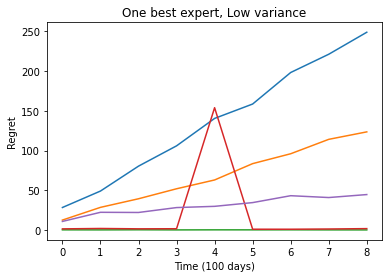

In [ ]:
n_days_list = np.arange(1, 10)*100
low_variance = experts_performance(n_days_list, 10, 0.5, one_best_expert)
plt.plot(low_variance, label=[1,2,3,4,5])
plt.title('One best expert, Low variance')
plt.xlabel('Time (100 days)')
plt.ylabel('Regret')

Text(0, 0.5, 'Regret')

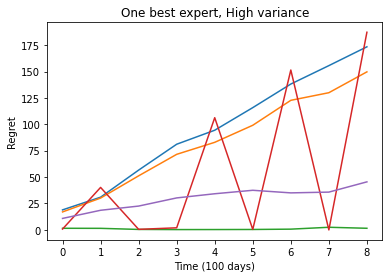

In [ ]:
high_variance = experts_performance(np.arange(1, 10)*100, 10, 2, one_best_expert)
plt.plot(high_variance)
plt.title('One best expert, High variance')
plt.xlabel('Time (100 days)')
plt.ylabel('Regret')

Text(0, 0.5, 'Regret')

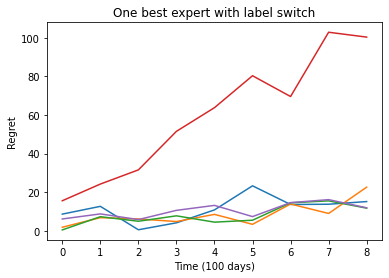

In [ ]:
switch = experts_performance(np.arange(1, 10)*100, 10, 1, switch_experts)
plt.plot(switch)
plt.title('One best expert with label switch')
plt.xlabel('Time (100 days)')
plt.ylabel('Regret')

Question: What if we had one "perfect expert" who always predicts correctly. How could we use that to improve our accuracy over time?

Answer:

You could construct a halving algorithm - each day, if we make a mistake, throw out all that advised you wrongly. Make maximum of log_2(x) mistakes since by majority rule, at most half are incorrect!


Question: Why is the halving algorithm especially vulnerable to the noise in the data?

Answer: The halving algorithm chooses the best expert within the first few days. If the actual best expert happens to do bad in those crucial first days, it can get eliminated, leading to the bad performance in the following days.

# Ensemble Methods

Now equipped with the multiplicative weights framework, let us explore the applications of this into machine learning, through ensemble methods. Here we will use sklearn to implement random forests and adaboost.

##Data Set

Sklearn has nice data sets we can use for this. For example, let us explore the moons data set. Here we get the data and partition it into training and testing.

In [ ]:
dataset=make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=42)
X,y=dataset

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

dataset2=load_iris(return_X_y=True)
X2,y2=dataset2

X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.2,random_state=42)

Visualize the train Data Set

(-2.0, 3.0, -2.5, 2.5)

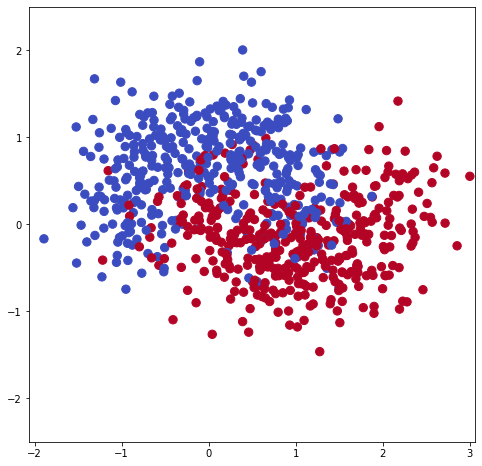

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([-2,3,-2.5,2.5])

## Random Forests (Bagging)

First, let us use a bagging method that was introduced to you previously, random forests. 


###Task 8: Implementing Random Forest

Random Forest is an example of the bagging that you have encountered in the previous assignments. By filling in the part of random forest classifier below, you will see that although it does combine data from different sources, it takes a simple average, differing from the multiplicative weights method.

Random Forest combines the classifications from different decision trees. In order to do this, you need to:

1. Create a smaller dataset by sampling with replacement from the main dataset

2. Train decision trees with the smaller dataset

3. Get predictions from each decision tree classifiers and take a poll to get prediction

In [ ]:
classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=42,
            splitter='best')
classifier.fit(X_train, y_train)
y_pred1 = classifier.predict(X_test)
score_dt = classifier.score(X_test, y_test)

sum_estimates = np.zeros(X_test.shape[0])
section_size = X_train.shape[0] // 2 #size of each section is 1/2 of entire dataset


#implement the random forest algorithm. You can use the skl library's decision tree
#remember random forest is essentially just taking the descrete toll of decision trees
for i in range(100):
  
  #YOUR CODE HERE
  #create a section from x__train
  cur_rand = random.randint(X_train.shape[0], size=section_size)
  section_x = X_train[cur_rand, :]
  section_y = y_train[cur_rand]
  #train them and get sum
  classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=42,
            splitter='best')
  classifier.fit(section_x, section_y)
  #get classifications
  y_pred = classifier.predict(X_test)
  sum_estimates += y_pred


#find the avg prediction
score_rf = accuracy_score(y_test, sum_estimates // 51)

print("Accuracy score of single Decision Tree:", score_dt)
print("Accuracy score of Random Forest:", score_rf)

Accuracy score of single Decision Tree: 0.78
Accuracy score of Random Forest: 0.845


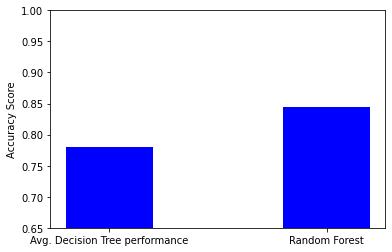

In [ ]:
labels = ["Avg. Decision Tree performance", "Random Forest"]
vals = [score_dt, score_rf]
x_pos = [i for i, _ in enumerate(labels)]
plt.bar(x_pos, vals, color='blue', width=0.4)
plt.ylabel("Accuracy Score")
plt.xticks(x_pos, labels)
plt.ylim(0.65, 1)


plt.show()

## Boosting 

Boosting is another method of combining models together for better performance, however, in a more principled manner than bagging. Let us first examine specifically a boosting algorithm called AdaBoost, and use that as a starting point from which we can then generalize.

In Adaboost, we create M different models, this time through a more intelligent process of iterative weight updates. The intuition is that some data points will be harder to classify than others. 

For example, consider a scenario in which you are trying to classify between digits. A poorly written “4” may look a lot like a “9” and thus be much harder to classify, say between a “1” and an “8”. 


Thus, we should focus more of our energy on these harder points - sounds like we should give each data point a weight. After each iteration, if we misclassified the point, we should increase its weight, and if we classified it correctly, we should decrease its weight, thus effectively shifting our focus towards the harder points. After doing this for each point, we now train a new model from the weighted points. Next, we repeat the weight update process on our new model. Repeat. Here is the psuedocode that you can use to help you implement the algorithm:

<img src='https://drive.google.com/uc?id=1j7Tk2UKwTRfKD2rmot6-Bt5zBFdIcVSJ'>

Two more abstracted details: how exactly do we train a model on data points which are weighted differently? Similarly to bagging, we use resampling. However, this time we sample based on a distribution according to the weights (this is why we normalize the weights!) instead of sampling uniformly. Thus, since the higher weight data points have higher probability mass and are more likely to be chosen for the training of the next model. This serves the purpose of the reweighting since now we are focusing our energy on those data points.

How do we aggregate the results of the M models? We need a second layer of weights for these models. Although the proof is out of scope, it turns out we can analytically derive an expression for these weights,
a_m =  1/2 * np.log((1. - e_m) / e_m)


Implementation for boosting and visualization methods were inspired by Xavier Bourret Sicotte's blog, https://xavierbourretsicotte.github.io/AdaBoost.html

###Task 9: Implementing Adaboost

In the cell below, implement Adaboost. Remember that Adaboost is an application of multiplicative weights update. However, in Adaboost, there is 2 sets of weights that you need to manage: weights of the datapoints, to choose which datapoints to focus on in the following iterations, and weights of the classifiers, to make predictions. 

Inside the for loop that you will fill in, you need to complete these 4 steps:

1. Build a classifier and train them with weights w (data point weights)

  - you can use sklearn decision tree classifier as the weak learner here

2. Compute the weighted error

3. Compute new weights for the training points

4. Set the classifier weight

In [ ]:
def adaboost_fit(X, y, M=10):
  #convert the y data into (1,-1) instead of (1,0). This is to keep consistency with the weak classifier
  # that will return (1,-1)
  y = y * 2 - 1

  #define variables
  #N is number of data points
  #predictions is the sum of the y predictions made by weak classifiers
  #w is the list of training point weights
  #a is the list of classifier weights, where a_m are mth classifier weight
  #e_m is the weighted error, a intermediate value used for the re_weight process
  N = len(y)
  classifier_list, predictions, w, a = [],[],[],[]

  #Initialize all the weights as 1/n
  w_i = np.ones(N) / N
  w.append(w_i.copy())

  #Repeat for m=1,...,M:
  for m in range(M):   

    #YOUR CODE HERE
    #Build a classifier and train them with weights w
    classifier = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
    classifier.fit(X, y, sample_weight=w_i)
    y_predict = classifier.predict(X)

    #intermediate step to get correct and incorrect points
    incorrect = (y_predict != y)
    correct = (y_predict == y)

    #Compute the weighted error
    e_m = np.dot(incorrect, w_i)
    
    #Set the classifier weight a_m
    a_m =  1/2 * np.log((1. - e_m) / e_m)

    #Re-weight the training points using the update rule
    w_i1 = w_i * incorrect * np.sqrt((1 - e_m) / e_m) 
    w_i2 = w_i * correct * np.sqrt(e_m / (1 - e_m))
    w_i = w_i1 + w_i2
    w_i /= w_i.sum()

    #Save the values from this iteration for future prediction and plotting
    classifier_list.append(classifier)
    predictions.append(y_predict.copy())
    a.append(a_m.copy())
    w.append(w_i.copy())

  #Python lists are converted to np arrays for consistency and convenience 
  classifier_list = np.asarray(classifier_list)
  predictions = np.asarray(predictions)
  w = np.asarray(w)
  a = np.asarray(a)
  
  return classifier_list, a

In [ ]:
def adaboost_predict(classifier_list, a, X_test):
  M = len(classifier_list)
  N = X_test.shape[0]
  predictions = np.zeros(N)

  for m in range(M):
    classifier = classifier_list[m]
    cur_pred = classifier.predict(X_test)
    predictions += cur_pred * a[m]

  pred = np.sign(predictions)
  return pred
    

In [ ]:
y_train_1 = y_train * 2 - 1
y_test_1 = y_test * 2 - 1


classifier_list, weights = adaboost_fit(X_train, y_train, M=100)
train_pred = adaboost_predict(classifier_list, weights, X_train)
test_pred = adaboost_predict(classifier_list, weights, X_test)
print("Training accuracy: ", accuracy_score(train_pred, y_train_1))
print("Test accuracy: ", accuracy_score(test_pred, y_test_1))

Training accuracy:  0.86875
Test accuracy:  0.845


In [ ]:
#multi class
y_train_2 = y2_train * 2 - 1
y_test_2 = y2_test * 2 - 1


classifier_list2, weights2 = adaboost_fit(X2_train, y2_train, M=100)
train_pred = adaboost_predict(classifier_list2, weights2, X2_train)
test_pred = adaboost_predict(classifier_list2, weights2, X2_test)
print("Training accuracy: ", accuracy_score(train_pred, y_train_2))
print("Test accuracy: ", accuracy_score(test_pred, y_test_2))

Training accuracy:  0.675
Test accuracy:  0.6333333333333333


##Visualizations

In [ ]:
def plot_adaboost(classifier_list,weights, X, y, N = 10,ax = None ):
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [adaboost_predict(classifier_list, weights, np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#DD2222', '#2222DD'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.3)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

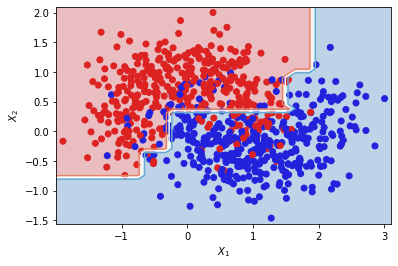

In [ ]:
plot_adaboost(classifier_list, weights, X_train, y_train, N = 50 )

# **Conclusion**

Thus, ensemble methods have their place as a fundamental range of techniques in machine learning. As the adage goes, the more the merrier. By intelligently combining the expertise of multiple models, we can surpass old limits. Now, you understand from a general sense, the intuition of ensemble methods by exploring the multiplicative weight updates algorithm and framework and how it applies to machine learning.

You learned bagging through the application of decision tree to random forests. Then, you learned boosting by implementing Adaboost and also using the library function. Finally, you compared and contrasted the performance of the two on a dataset. This was no easy task, congratulations on the great work!


# Optional

Furthermore, Adaboost may be generalized to gradient boosting by now allowing different (differentiable) loss functions instead of just Adaboost's exponential loss. You may code that method up here and compare its performance to our previous methods!

In [ ]:
classifier = GradientBoostingClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)


0.84

In [ ]:
classifier = HistGradientBoostingClassifier(max_iter=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.82

sources
https://github.com/jaimeps/adaboost-implementation/blob/master/adaboost.py